Original implementation of gae-sc method
(https://github.com/ciortanmadalina/gae-sc)

In [ ]:
# !pip install pandas==1.2.1

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, 
                             silhouette_score, calinski_harabasz_score)
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
from tqdm.notebook import tqdm
import models
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import pickle

import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using backend: pytorch
/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


# Start by combining the results of all methods into one file per type of data

This file will be used for all plots.

In [2]:
path = ".."
for category in [
        
        "imbalanced_data",
        "balanced_data",
        "real_data",
]:

    df = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_gae.pkl")
    df_k = df[[
        'dataset',
#         'dropout',
        'kmeans_ari',
        'kmeans_nmi',
        'kmeans_sil',
        'kmeans_cal',
        'run',
        "tot_kmeans_time",
        'kmeans_pred',
    ]].rename(
        columns={
            'kmeans_ari': "ARI",
            'kmeans_nmi': "NMI",
            'kmeans_pred': 'pred',
            'kmeans_sil': "sil",
            'kmeans_cal': "cal",
            'tot_kmeans_time': 'time'
        })
    df_k["method"] = "graph-sc(KM)"

    df_l = df[[
        'dataset',
#         'dropout',
        'leiden_ari',
        'leiden_nmi',
        'leiden_sil',
        'leiden_cal',
        'run',
        'tot_leiden_time',
        'leiden_pred',
    ]].rename(
        columns={
            'leiden_ari': "ARI",
            'leiden_nmi': "NMI",
            'leiden_pred': 'pred',
            'leiden_sil': "sil",
            'leiden_cal': "cal",
            'tot_leiden_time': 'time'
        })

    df_l["method"] = "graph-sc(LD)"

    r_data = pd.read_pickle(f"{path}/R/{category}.pkl")
    
    
    scGNN = pd.read_pickle(
            f"{path}/output/pickle_results/{category}/{category}_scGNN.pkl"
        )
    scGNN["method"] = "scGNN"

    scDeepCluster = pd.read_pickle(
            f"{path}/output/pickle_results/{category}/{category}_scDeepCluster.pkl"
        )
    scDeepCluster["method"] = "scDeepCluster"

    sczi = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_sczi.pkl")
    sczi["method"] = "scziDesk"

    scedar = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_scedar.pkl")
    scedar["method"] = "scedar"

    scanpy = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_scanpy.pkl")
    scanpy["method"] = "scanpy-seurat"

    scrna = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_scrna.pkl")
    scrna["method"] = "scrna"

    pca_kmeans = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_pca_kmeans.pkl")
    pca_kmeans["method"] = "pca50_kmeans"

    scvi = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_scvi.pkl")
    scvi["method"] = "scvi"

    desc = pd.read_pickle(
        f"{path}/output/pickle_results/{category}/{category}_desc.pkl")
    desc["pred"] = desc["pred"].apply(lambda x: x.to_list())
    desc["method"] = "desc"

    all_data = pd.concat([
        df_k, df_l, r_data, desc, pca_kmeans, sczi, scDeepCluster, scedar,
        scanpy, scvi, scrna, scGNN
    ])
    all_data = all_data.reset_index(drop=True)

    all_data = all_data.rename(columns={
        "sil": "Silhouette",
        "cal": "Calinski"
    })

    path = ".."
    if category in ["balanced_data", "imbalanced_data"]:
        files = glob2.glob(f'{path}/R/simulated_data/{category}/*.h5')
        files = [
            f[len(f"{path}/R/simulated_data/{category}/"):-3] for f in files
        ]
    else:
        files = glob2.glob(f'{path}/real_data/*.h5')
        files = [f[len(f"{path}/real_data/"):-3] for f in files]
    print(files)

    if category in ["imbalanced_data", "balanced_data"]:
        sc_dropout = {
            'data_1c8': 0.3,
            'data_-1c4': 0.08,
            'data_-1c8': 0.08,
            'data_0c4': 0.17,
            'data_0c8': 0.17,
            'data_0c16': 0.17,
            'data_1.5c4': 0.38,
            'data_1c4': 0.3,
            'data_1.5c8': 0.38,
            'data_1.5c16': 0.38,
            'data_-1c16': 0.08,
            'data_1c16': 0.3,
            'data_0c32': 0.17,
            'data_1.5c32': 0.38,
            'data_1c32': 0.3,
            'data_-1c32': 0.08
        }
        all_data["dropout"] = all_data["dataset"].apply(
            lambda x: sc_dropout[x])
        all_data["nb_clust"] = all_data["dataset"].apply(
            lambda x: int(x.split("c")[1]))
    ordered_methods = [
        'graph-sc(KM)',
        'scziDesk',
        'scDeepCluster',
        'scrna',
        'cidr',
        'soup',
        'pca50_kmeans',
        'graph-sc(LD)',
        'scGNN',
        'desc',
        'scanpy-seurat',
        'scedar',
        'scvi',
        'raceid',
    ]
    ordered_methods = dict(
        zip(ordered_methods, np.arange(len(ordered_methods))))

    all_data["order"] = all_data["method"].apply(lambda x: ordered_methods[x])

    all_data.to_pickle(
        f"{path}/output/pickle_results/{category}/{category}_combined.pkl")

['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']
['data_1c8', 'data_-1c4', 'data_-1c8', 'data_0c4', 'data_0c8', 'data_0c16', 'data_1.5c4', 'data_1c4', 'data_1.5c8', 'data_1.5c16', 'data_-1c16', 'data_1c16']
['Quake_Smart-seq2_Trachea', 'Quake_Smart-seq2_Diaphragm', 'Quake_10x_Spleen', 'Young', 'mouse_ES_cell', 'Adam', 'Quake_10x_Bladder', 'Quake_Smart-seq2_Lung', 'Quake_10x_Limb_Muscle', 'worm_neuron_cell', 'mouse_bladder_cell', 'Romanov', 'Quake_Smart-seq2_Limb_Muscle', 'Muraro', '10X_PBMC']


In [3]:
all_data.groupby("method").mean()

,ARI,NMI,Silhouette,Calinski,time,order
method,,,,,,
cidr,0.489201,0.571011,0.080116,236.228635,10.014428,4
desc,0.443275,0.679299,0.557783,5189.773998,52.905305,9
graph-sc(KM),0.783227,0.817189,0.478529,1764.950577,17.489118,0
graph-sc(LD),0.525911,0.724871,0.301866,1095.618432,25.185104,7
pca_kmeans,0.177185,0.261654,0.492562,5032.781468,1.249680,6
raceid,0.357886,0.545450,0.297905,20823.706671,12.976063,13
scDeepCluster,0.588561,0.705172,0.622954,8022.017524,6121.418068,2
scGNN,0.396190,0.565139,0.253787,1139.073544,142.989101,8
scanpy-seurat,0.421980,0.683175,0.446375,7545.074453,10.617077,10


In [ ]:
# category = "imbalanced_data"
# category = "balanced_data"
# category = "real_data"
# all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")

In [2]:
import seaborn as sns
ordered_methods = [
    'graph-sc(KM)',
    'scziDesk',
    'scDeepCluster',
    'scrna',
    'cidr',
    'soup',
    'pca_kmeans',
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]

ordered_methods_map = dict(
        zip(ordered_methods, np.arange(len(ordered_methods))))


clrs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#7f7f7f', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b',
    '#c49c94', '#e377c2', '#f7b6d2', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'
]

methods_no_clust = [
    'graph-sc(LD)',
    'scGNN',
    'desc',
    'scanpy-seurat',
    'scedar',
    'scvi',
    'raceid',
]

# Simulated methods Comparaision

# Per datasets

In [ ]:
plt.figure(figsize = (14, 13))
nrows = 4
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["graph-sc(KM)"]
rankLD = rank.T["graph-sc(LD)"]

ax = plt.subplot(nrows, 1, 1)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
# plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a1) ARI per dataset - Balanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 2)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.9, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(a2)  ARI per dataset - Balanced data", fontweight = "bold")

###############################################

category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)
rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(3).T
rank = rank.rank(ascending=False, method = "min")
rankKM = rank.T["graph-sc(KM)"]
rankLD = rank.T["graph-sc(LD)"]

ax = plt.subplot(nrows, 1, 3)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[:6]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
# Ranking

for i, d in enumerate(seld):
    plt.text(i-0.1, 1, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
# plt.legend(bbox_to_anchor=(0, 1.35), loc=2, borderaxespad=0., ncol=7)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(b1) ARI per dataset - Imbalanced data", fontweight = "bold")


ax = plt.subplot(nrows, 1, 4)
seld = all_data.sort_values(by=["dropout", 'nb_clust', "order"])["dataset"].unique()[6:]
sns.barplot(x = "label", y="ARI", 
                data = all_data[all_data["dataset"].isin(seld)].sort_values(by=["dropout", 'nb_clust', "order"]),
                hue = "method",
               palette=clrs,
               edgecolor='black',
        linewidth=0.8)
plt.xticks(fontsize=13)
for i, d in enumerate(seld):
    plt.text(i-0.1, 0.7, f"#{int(rankKM[d])}, #{int(rankLD[d])}", fontsize=13)
plt.legend([])
sns.despine()
plt.xlabel("")
ymin, ymax = ax.get_ylim()
plt.ylim((ymin, ymax + 0.05))
plt.title("(b2)  ARI per dataset - Imbalanced data", fontweight = "bold")

plt.tight_layout()
plt.savefig(f"../diagrams/simulated_per_datasets.pdf", bbox_inches='tight')

# Simulated comparison overview

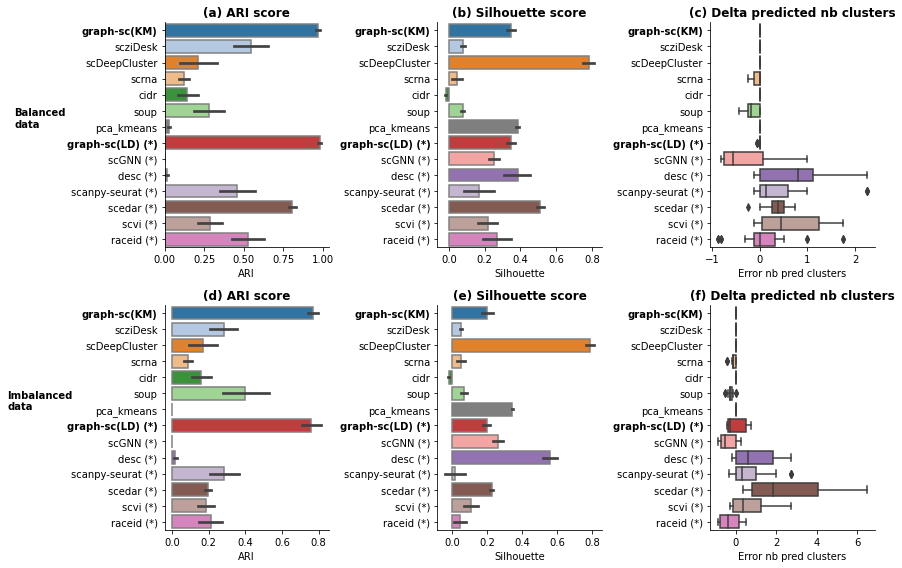

In [3]:
plt.figure(figsize = (13, 8))
nrows = 2
category = "balanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)


ax = plt.subplot(nrows, 3, 1)

sns.barplot(y = "method", x="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='gray',
        linewidth=1.5)

plt.ylabel("")
plt.title("(a) ARI score", fontweight = "bold")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
####### LABEL
plt.text(-0.95, 6, "Balanced\ndata", fontweight = "bold")
plt.xlabel("ARI")
sns.despine()
##
ax = plt.subplot(nrows, 3, 2)
sns.barplot(y = "method", x="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='gray',
        linewidth=1.5)


plt.ylabel("")
plt.title("(b) Silhouette score", fontweight = "bold")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 3)
sns.boxplot(y = "method", x="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)

plt.xlabel("Error nb pred clusters")
sns.despine()
plt.title(f"(c) Delta predicted nb clusters", fontweight = "bold")
plt.ylabel("")

# plt.text(-0.4, 1.9, "2x more clusters")
# plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()
###############################################
category = "imbalanced_data"
all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["label"] =all_data.apply(lambda x : f"dropout: {x['dropout']}\n{x['nb_clust']} clusters", axis = 1)
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clust"])/x["nb_clust"], 
                                           axis = 1)


ax = plt.subplot(nrows, 3, 4)
sns.barplot(y = "method", x="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='gray',
        linewidth=1.5)

plt.ylabel("")
plt.title("(d) ARI score", fontweight = "bold")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
####### LABEL
plt.text(-0.9, 6, "Imbalanced\ndata", fontweight = "bold")
plt.xlabel("ARI")
sns.despine()
##
ax = plt.subplot(nrows, 3, 5)
sns.barplot(y = "method", x="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='gray',
        linewidth=1.5)


plt.ylabel("")
plt.title("(e) Silhouette score", fontweight = "bold")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()

ax = plt.subplot(nrows, 3, 6)
sns.boxplot(y = "method", x="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)

plt.xlabel("Error nb pred clusters")
sns.despine()
plt.title(f"(f) Delta predicted nb clusters", fontweight = "bold")
plt.ylabel("")

# plt.text(-0.4, 1.9, "2x more clusters")
# plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()

plt.tight_layout()
plt.savefig(f"../diagrams/simulated_overall.pdf", bbox_inches='tight')

In [ ]:
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])

In [ ]:
all_data[all_data["method"]=="scGNN"]

# Overview real scRNA-seq data

In [4]:
path = ".."

In [5]:
category = "real_data"
desc = pd.read_pickle(f"{path}/output/pickle_results/real_data/description.pkl")
all_data = pd.read_pickle(f"{path}/output/pickle_results/{category}/{category}_combined.pkl")
all_data = pd.merge(all_data, desc[["dataset", "nb_clusters"]], on = "dataset")
all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clusters"])/x["nb_clusters"], 
                                           axis = 1)

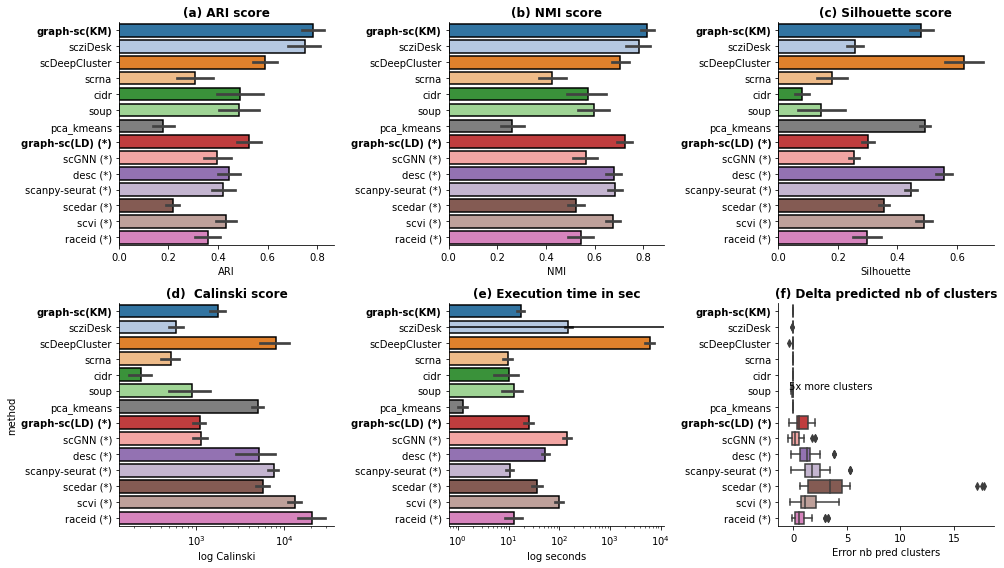

In [6]:
plt.figure(figsize=(14, 8))
letters = ["(a)", "(b)", "(c)", "(d)",
           "(e)", "(f)","(g)" ,"(h)",
           "(i)","(j)","(k)", "(l)"]
titles = ["real data"]
nb_rows=2
i = 0
ax = plt.subplot(nb_rows,3,i*4 +1)
sns.barplot(y = "method", x="ARI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)

plt.title(f"{letters[i*4]} ARI score", fontweight = "bold")
plt.ylabel("")
sns.despine()

plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,3,i*4 +2)
sns.barplot(y = "method", x="NMI", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)

plt.ylabel("")
plt.title(f"{letters[i*4 +1]} NMI score", fontweight = "bold")
# for j in range(7,13):
#     plt.text(j, 0.8, "*")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 

ax = plt.subplot(nb_rows,3,i*4 +3)
sns.barplot(y = "method", x="Silhouette", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)

plt.title(f"{letters[i*4 +2]} Silhouette score", fontweight = "bold")
plt.ylabel("")
# for j in range(7,13):
#     plt.text(j, 0.6, "*")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()

## Nb predicted clusters
ax = plt.subplot(nb_rows,3,i*4 +4)
g= sns.barplot(y = "method", x="Calinski", data = all_data.sort_values(by="order"),
           palette=clrs,
           edgecolor='black',
    linewidth=1.5)
g.set(xscale="log")

plt.xlabel("log Calinski")
plt.title(f"{letters[i*4 +3]}  Calinski score", fontweight = "bold")
# plt.ylabel("")
# for j in range(7,13):
#     plt.text(j, 20000, "*")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()
    
    
ax = plt.subplot(nb_rows, 3, 5)
g = sns.barplot(y = "method", x="time", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
           linewidth=1.5
           )
g.set(xscale="log")
plt.axhline(y=1, c = "black")
plt.xlabel("log seconds")

plt.title(f"(e) Execution time in sec", fontweight = "bold")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()
plt.ylabel("")


ax = plt.subplot(nb_rows, 3, 6)
sns.boxplot(y = "method", x="nb_pred_clust", data = all_data.sort_values(by="order"),
               palette=clrs,
        linewidth=1.5)

plt.xlabel("Error nb pred clusters")
sns.despine()
plt.title(f"(f) Delta predicted nb of clusters", fontweight = "bold")
plt.ylabel("")

plt.text(-0.4, 4.9, "5x more clusters")
# plt.text(-0.4, -0.6, "1/2x less clusters")
plt.gca().get_yticklabels()[0].set_fontweight('bold') 
plt.gca().get_yticklabels()[7].set_fontweight('bold') 
sns.despine()

plt.tight_layout()
plt.savefig(f"{path}/diagrams/real.pdf", bbox_inches='tight')

In [8]:
all_data.groupby("method").mean()

,ARI,NMI,Silhouette,Calinski,time,order,nb_pred_clust
method,,,,,,,
cidr,0.489201,0.571011,0.080116,236.228635,10.014428,4,0.000000
desc (*),0.443275,0.679299,0.557783,5189.773998,52.905305,9,1.303348
graph-sc(KM),0.783227,0.817189,0.478529,1764.950577,17.489118,0,0.000000
graph-sc(LD) (*),0.525911,0.724871,0.301866,1095.618432,25.185104,7,0.818242
pca_kmeans,0.177185,0.261654,0.492562,5032.781468,1.249680,6,0.000000
raceid (*),0.357886,0.545450,0.297905,20823.706671,12.976063,13,0.880430
scDeepCluster,0.588561,0.705172,0.622954,8022.017524,6121.418068,2,-0.013793
scGNN (*),0.396190,0.565139,0.253787,1139.073544,142.989101,8,0.280091
scanpy-seurat (*),0.421980,0.683175,0.446375,7545.074453,10.617077,10,1.904899


# Overview all datasets

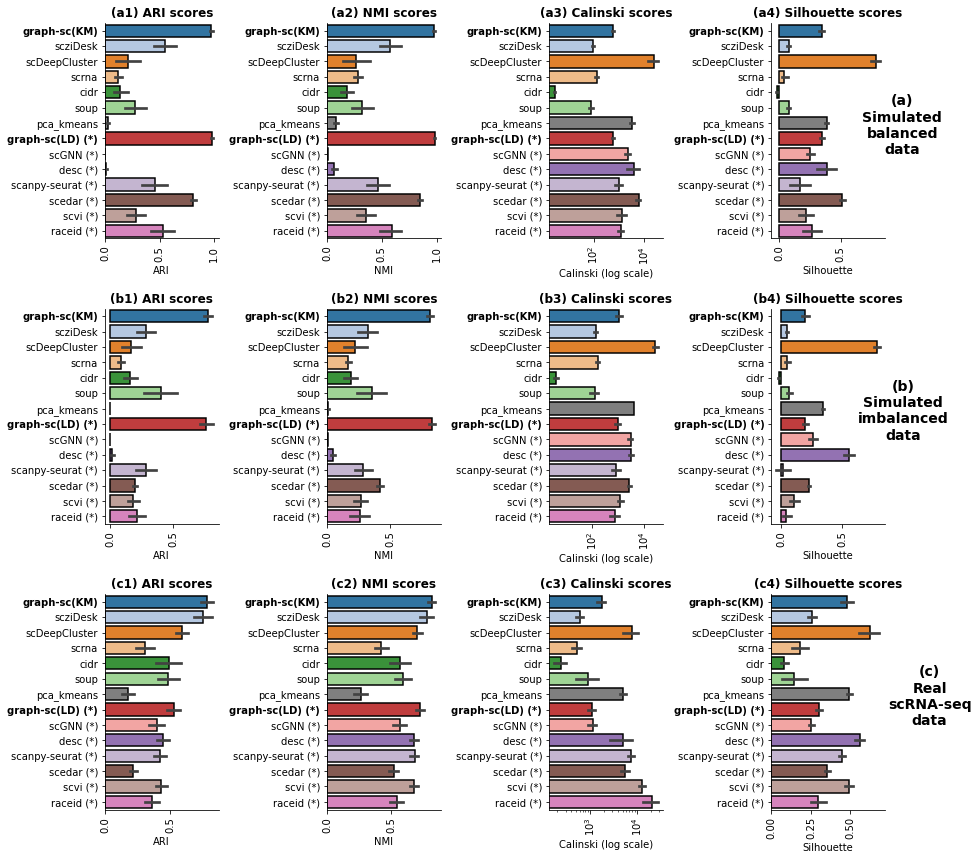

In [10]:
plt.figure(figsize=(14, 12))
letters = ["a", "b", "c"]
titles = ["(a)\nSimulated\nbalanced\ndata", "(b)\nSimulated\nimbalanced\ndata", "(c)\nReal\nscRNA-seq\ndata"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):
    all_data = pd.read_pickle(f"../output/pickle_results/{category}/{category}_combined.pkl")
    all_data["method"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
    ax = plt.subplot(3,4,i*4 +1)

    sns.barplot(y = "method",x ="ARI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"({letters[i]}1) ARI scores", fontweight = "bold")
    plt.ylabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +2)
    sns.barplot(y = "method",x ="NMI", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.ylabel("")
    plt.title(f"({letters[i]}2) NMI scores", fontweight = "bold")

    ax = plt.subplot(3,4,i*4 +3)
    g= sns.barplot(y = "method",x ="Calinski", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    g.set(xscale="log")
    plt.xticks(rotation = 90)
    plt.title(f"({letters[i]}3) Calinski scores", fontweight = "bold")
    plt.xlabel("Calinski (log scale)")
    plt.ylabel("")
    sns.despine()

    ax = plt.subplot(3,4,i*4 +4)
    sns.barplot(y = "method",x ="Silhouette", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"({letters[i]}4) Silhouette scores", fontweight = "bold")
    plt.ylabel("")
     ####### LABEL
    plt.text(1, 8,titles[i], fontweight = "bold", fontsize = 14, ha ='center')
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_barplot.pdf", bbox_inches='tight')

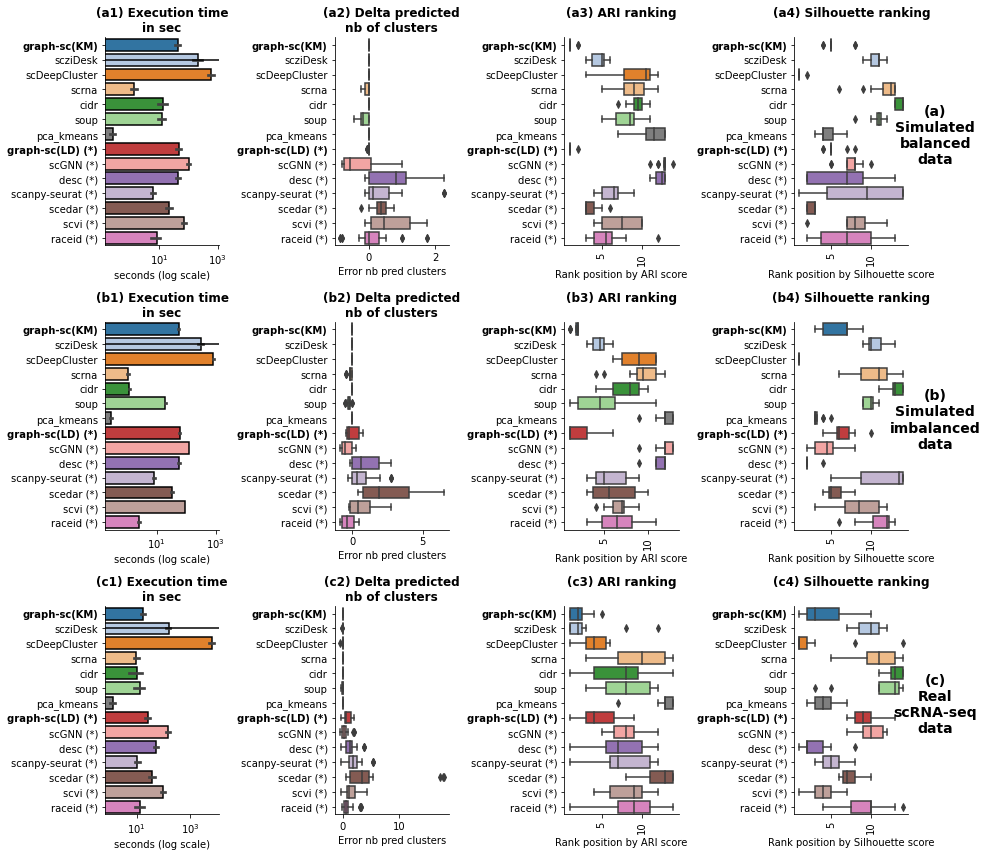

In [11]:
plt.figure(figsize=(14, 12))
letters = ["a", "b", "c"]
titles = ["(a)\nSimulated\nbalanced\ndata", "(b)\nSimulated\nimbalanced\ndata", "(c)\nReal\nscRNA-seq\ndata"]
for i, category in enumerate (["balanced_data", "imbalanced_data", "real_data"] ):

    desc = pd.read_pickle(f"{path}/output/pickle_results/{category}/description.pkl")
    all_data = pd.read_pickle(f"{path}/output/pickle_results/{category}/{category}_combined.pkl")
    all_data = pd.merge(all_data, desc[["dataset", "nb_clusters"]], on = "dataset")
    all_data["method_name"] = all_data["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
    all_data["nb_pred_clust"] = all_data["pred"].apply(lambda x: np.unique(x).shape[0])
    all_data["nb_pred_clust"] = all_data.apply(lambda x: (x["nb_pred_clust"]- x["nb_clusters"])/x["nb_clusters"], 
                                               axis = 1)
    
    ax = plt.subplot(3,4,i*4 +1)
    g = sns.barplot(y = "method_name", x="time", data = all_data.sort_values(by="order"),
               palette=clrs,
               edgecolor='black',
           linewidth=1.5
           )
    g.set(xscale="log")
    plt.axhline(y=1, c = "black")
    plt.xlabel("seconds (log scale)")

    plt.title(f"({letters[i]}1) Execution time\nin sec", fontweight = "bold")
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold') 
    sns.despine()
    plt.ylabel("")
    

    ax = plt.subplot(3,4,i*4 +2)
    sns.boxplot(y = "method_name", x="nb_pred_clust", data = all_data.sort_values(by="order"),
                   palette=clrs,
            linewidth=1.5)

    plt.xlabel("Error nb pred clusters")
    sns.despine()
    plt.title(f"({letters[i]}2) Delta predicted\nnb of clusters", fontweight = "bold")
    plt.ylabel("")

#     plt.text(-0.4, 4.9, "5x more clusters")
    # plt.text(-0.4, -0.6, "1/2x less clusters")
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold') 
    sns.despine()



    ax = plt.subplot(3,4,i*4 +3)
    rank = all_data.groupby(["dataset", "method"])["ARI"].mean().unstack("method").round(2).T
    rank = rank.rank(ascending=False, method = "min")
    rank = rank.reset_index()
    rank = pd.melt(rank, id_vars="method")
    rank["order"] = rank["method"].apply(lambda x: ordered_methods_map[x])
    rank["method"] = rank["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
    
    sns.boxplot(y = "method",x ="value", data = rank.sort_values(by="order"),
               palette=clrs,
#                edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"({letters[i]}3) ARI ranking\n", fontweight = "bold")
    plt.ylabel("")
    plt.xlabel("Rank position by ARI score")
    sns.despine()
    
    


    ax = plt.subplot(3,4,i*4 +4)
    rank = all_data.groupby(["dataset", "method"])["Silhouette"].mean().unstack("method").round(2).T
    rank = rank.rank(ascending=False, method = "min")
    rank = rank.reset_index()
    rank = pd.melt(rank, id_vars="method")
    rank["order"] = rank["method"].apply(lambda x: ordered_methods_map[x])
    rank["method"] = rank["method"].apply(lambda x: f"{x} (*)" if x in methods_no_clust else x )
    
    sns.boxplot(y = "method",x ="value", data = rank.sort_values(by="order"),
               palette=clrs,
#                edgecolor='black',
        linewidth=1.5)
    plt.gca().get_yticklabels()[0].set_fontweight('bold') 
    plt.gca().get_yticklabels()[7].set_fontweight('bold')
    plt.xticks(rotation = 90)
    plt.title(f"({letters[i]}4) Silhouette ranking\n ", fontweight = "bold")
    plt.ylabel("")
    plt.xlabel("Rank position by Silhouette score")
    sns.despine()

    
#      ####### LABEL
    plt.text(18, 8,titles[i], fontweight = "bold", fontsize = 14, ha ='center')
    sns.despine()
plt.tight_layout()
plt.savefig(f"../diagrams/all_ranking.pdf", bbox_inches='tight')

In [13]:
category = "balanced_data"
all_data = pd.read_pickle(f"{path}/output/pickle_results/{category}/{category}_combined.pkl")
all_data.groupby("method").mean().round(2)

,ARI,NMI,Silhouette,Calinski,time,dropout,nb_clust,order
method,,,,,,,,
cidr,0.14,0.18,-0.02,2.90,13.57,0.23,9.33,4.0
desc,0.01,0.07,0.38,3918.35,45.45,0.23,9.33,9.0
graph-sc(KM),0.97,0.98,0.35,598.25,43.05,0.23,9.33,0.0
graph-sc(LD),0.98,0.98,0.35,599.57,46.55,0.23,9.33,7.0
pca_kmeans,0.03,0.08,0.38,3310.05,0.26,0.23,9.33,6.0
raceid,0.53,0.60,0.27,1195.79,8.17,0.23,9.33,13.0
scDeepCluster,0.21,0.26,0.78,23895.66,614.66,0.23,9.33,2.0
scGNN,0.00,0.01,0.25,2301.16,102.96,0.23,9.33,8.0
scanpy-seurat,0.46,0.47,0.17,1004.67,6.29,0.23,9.33,10.0


In [15]:
category = "imbalanced_data"
all_data = pd.read_pickle(f"{path}/output/pickle_results/{category}/{category}_combined.pkl")
all_data.groupby("method").mean().round(2)

,ARI,NMI,Silhouette,Calinski,time,dropout,nb_clust,order
method,,,,,,,,
cidr,0.16,0.19,-0.02,3.99,1.18,0.23,9.33,4.0
desc,0.02,0.05,0.56,3005.81,56.63,0.23,9.33,9.0
graph-sc(KM),0.77,0.82,0.20,1074.14,54.56,0.23,9.33,0.0
graph-sc(LD),0.76,0.83,0.20,934.04,59.86,0.23,9.33,7.0
pca_kmeans,0.00,0.01,0.34,3943.17,0.28,0.23,9.33,6.0
raceid,0.21,0.26,0.04,752.19,2.54,0.23,9.33,13.0
scDeepCluster,0.17,0.22,0.79,26036.40,809.27,0.23,9.33,2.0
scGNN,0.00,0.00,0.26,2899.82,123.53,0.23,9.33,8.0
scanpy-seurat,0.29,0.29,0.01,836.55,8.09,0.23,9.33,10.0


In [18]:
category = "real_data"
all_data = pd.read_pickle(f"{path}/output/pickle_results/{category}/{category}_combined.pkl")
all_data.groupby("method").mean().round(2)

,ARI,NMI,Silhouette,Calinski,time,order
method,,,,,,
cidr,0.49,0.57,0.08,236.23,10.01,4
desc,0.44,0.68,0.56,5189.77,52.91,9
graph-sc(KM),0.78,0.82,0.48,1764.95,17.49,0
graph-sc(LD),0.53,0.72,0.30,1095.62,25.19,7
pca_kmeans,0.18,0.26,0.49,5032.78,1.25,6
raceid,0.36,0.55,0.30,20823.71,12.98,13
scDeepCluster,0.59,0.71,0.62,8022.02,6121.42,2
scGNN,0.40,0.57,0.25,1139.07,142.99,8
scanpy-seurat,0.42,0.68,0.45,7545.07,10.62,10


In [20]:
all_data.groupby(["method", "dataset"])["Silhouette"].mean().round(2).unstack("dataset")

dataset,10X_PBMC,Adam,Muraro,Quake_10x_Bladder,Quake_10x_Limb_Muscle,Quake_10x_Spleen,Quake_Smart-seq2_Diaphragm,Quake_Smart-seq2_Limb_Muscle,Quake_Smart-seq2_Lung,Quake_Smart-seq2_Trachea,Romanov,Young,mouse_ES_cell,mouse_bladder_cell,worm_neuron_cell
method,,,,,,,,,,,,,,,
cidr,0.03,0.11,0.05,0.25,0.08,0.03,0.11,0.07,0.01,0.08,0.07,-0.00,0.02,0.13,0.16
desc,0.63,0.62,0.55,0.53,0.60,0.74,0.35,0.49,0.50,0.52,0.52,0.62,0.44,0.59,0.67
graph-sc(KM),0.48,0.34,0.58,0.73,0.56,0.57,0.59,0.58,0.49,0.42,0.47,0.35,0.50,0.31,0.21
graph-sc(LD),0.28,0.27,0.36,0.20,0.35,0.17,0.30,0.28,0.46,0.31,0.31,0.31,0.36,0.30,0.25
pca_kmeans,0.40,0.49,0.46,0.64,0.48,0.50,0.49,0.46,0.50,0.41,0.56,0.48,0.48,0.46,0.58
raceid,0.23,0.05,0.54,0.19,0.28,0.22,0.31,0.43,0.26,0.31,0.37,0.32,0.16,0.27,0.53
scDeepCluster,0.74,0.68,0.66,0.75,0.79,-0.00,0.44,0.52,0.68,0.34,0.61,0.76,0.50,0.83,0.74
scGNN,0.30,0.19,0.33,0.27,0.29,0.21,0.19,0.26,0.20,0.23,0.21,0.24,0.38,0.29,0.22
scanpy-seurat,0.47,0.43,0.48,0.39,0.41,0.33,0.44,0.47,0.61,0.49,0.39,0.47,0.37,0.48,0.47


In [25]:
desc["nbcels"] = desc["size"].apply(lambda x: int(x.split("x")[0]))

In [26]:
desc.mean()

nb_clusters            7.600000
sparsity               0.885123
max_value              8.533333
non_zero_mean          1.797747
non_zero_median        1.637572
non_zero_skew          1.829031
non_zero_kurosis       6.146878
nbcels              3281.000000
dtype: float64